Key center: C#
Breaking method: minor thirds
Chosen permutation: ('E', 'A#', 'G', 'C#')
Time signature: 4/4


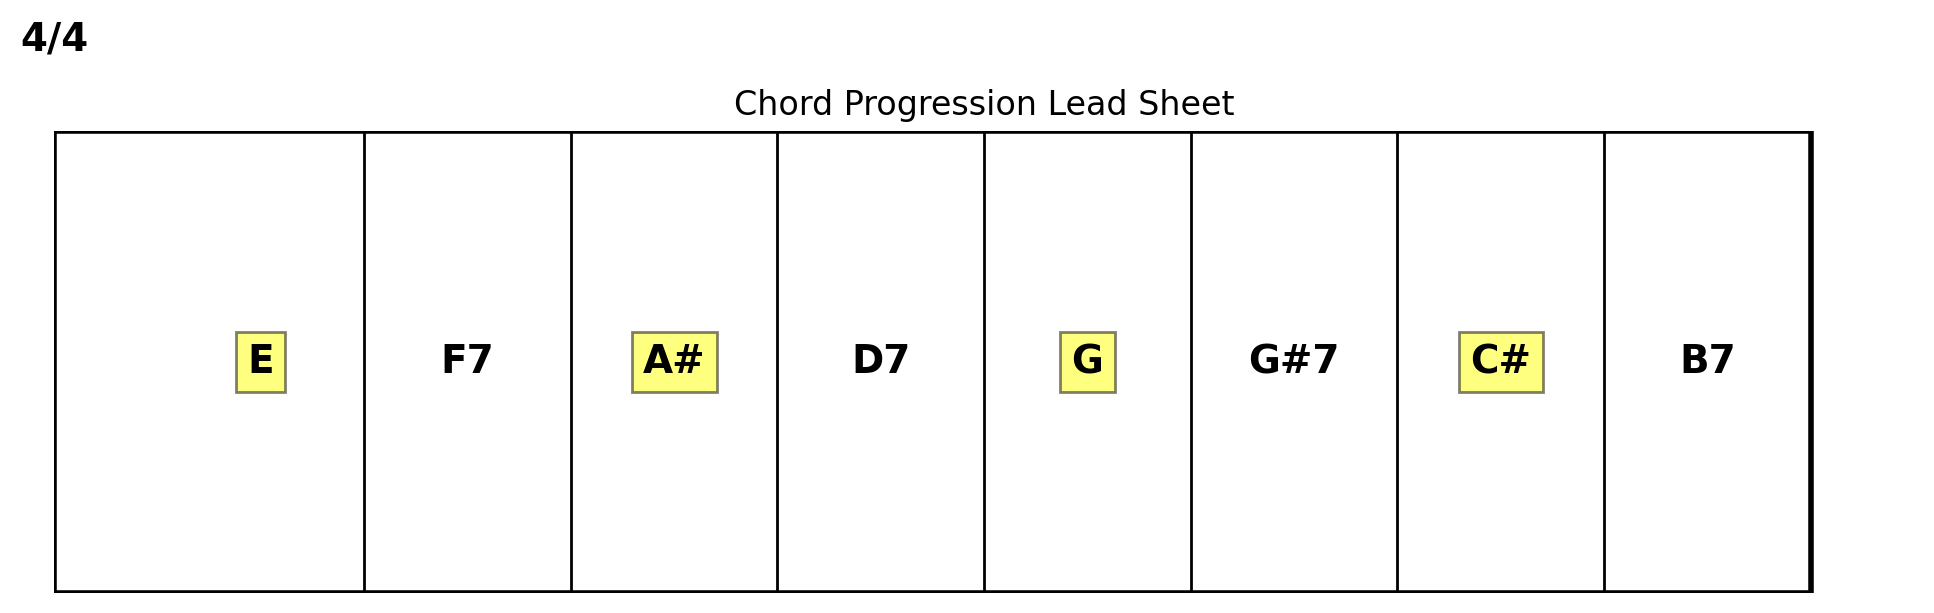

In [8]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from itertools import permutations
import matplotlib.pyplot as plt
import random
import music21
import pygame

# Define a mapping from qubit states to musical notes
note_mapping = {
    '0000': 'C', '0001': 'C#', '0010': 'D', '0011': 'D#',
    '0100': 'E', '0101': 'F', '0110': 'F#', '0111': 'G',
    '1000': 'G#', '1001': 'A', '1010': 'A#', '1011': 'B',
    '1100': 'C', '1101': 'C#', '1110': 'D', '1111': 'D#'
}

# Define note to MIDI mapping
note_to_midi = {
    'C': 60, 'C#': 61, 'D': 62, 'D#': 63,
    'E': 64, 'F': 65, 'F#': 66, 'G': 67,
    'G#': 68, 'A': 69, 'A#': 70, 'B': 71
}

# Define major and minor third mappings
major_thirds = {
    'C': ['C', 'E', 'G#'], 'C#': ['C#', 'E#', 'A'], 'D': ['D', 'F#', 'A#'], 'D#': ['D#', 'G', 'B'],
    'E': ['E', 'G#', 'C'], 'F': ['F', 'A', 'C#'], 'F#': ['F#', 'A#', 'D'], 'G': ['G', 'B', 'D#'],
    'G#': ['G#', 'C', 'E'], 'A': ['A', 'C#', 'F'], 'A#': ['A#', 'D', 'F#'], 'B': ['B', 'D#', 'G']
}

minor_thirds = {
    'C': ['C', 'D#', 'F#', 'A'], 'C#': ['C#', 'E', 'G', 'A#'], 'D': ['D', 'F', 'G#', 'B'], 
    'D#': ['D#', 'F#', 'A', 'C'], 'E': ['E', 'G', 'A#', 'C#'], 'F': ['F', 'G#', 'B', 'D'], 
    'F#': ['F#', 'A', 'C', 'D#'], 'G': ['G', 'A#', 'C#', 'E'], 'G#': ['G#', 'B', 'D', 'F'], 
    'A': ['A', 'C', 'D#', 'F#'], 'A#': ['A#', 'C#', 'E', 'G'], 'B': ['B', 'D', 'F', 'G#']
}

# Define time signatures mapping
time_signatures = {
    '00': '4/4', '01': '3/4', '10': '6/8', '11': '12/8'
}

# Quantum simulator
simulator = Aer.get_backend('qasm_simulator')

def get_v7_chord(note):
    v7_mapping = {
        'C': 'G7', 'C#': 'G#7', 'D': 'A7', 'D#': 'A#7',
        'E': 'B7', 'F': 'C7', 'F#': 'C#7', 'G': 'D7',
        'G#': 'D#7', 'A': 'E7', 'A#': 'F7', 'B': 'F#7'
    }
    return v7_mapping.get(note, '')

def handle_octave_breaking_and_progression():
    # Quantum circuit to determine the key center
    qc_key_center = QuantumCircuit(4)
    qc_key_center.h(range(4))
    qc_key_center.measure_all()
    
    result_key_center = simulator.run(transpile(qc_key_center, simulator)).result()
    counts_key_center = result_key_center.get_counts()
    
    most_probable_state_key_center = max(counts_key_center, key=counts_key_center.get)
    key_center = note_mapping[most_probable_state_key_center]
    
    qc2 = QuantumCircuit(3)
    qc2.h(range(3))
    qc2.measure_all()

    result2 = simulator.run(transpile(qc2, simulator)).result()
    counts2 = result2.get_counts()

    most_probable_state2 = max(counts2, key=counts2.get)
    if most_probable_state2[:2] == '00':
        breaking_method = 'minor thirds'
        progression = minor_thirds[key_center]
    else:
        breaking_method = 'major thirds'
        progression = major_thirds[key_center]

    permutations_list = list(permutations(progression))
    random.seed(int(most_probable_state2, 2))  # Seed the random number generator with the quantum measurement
    random.shuffle(permutations_list)  # Shuffle the permutations list

    permutation_index = int(most_probable_state2[2:], 2) % len(permutations_list)
    permutation = permutations_list[permutation_index]

    progression_with_v7 = []
    for i in range(len(permutation) - 1):
        progression_with_v7.append(permutation[i])
        v7_chord = get_v7_chord(permutation[i+1])
        if v7_chord:
            progression_with_v7.append(v7_chord)
    progression_with_v7.append(permutation[-1])

    # Add the V7 chord of the first chord at the end of the progression
    v7_of_first_chord = get_v7_chord(progression_with_v7[0])
    if v7_of_first_chord:
        progression_with_v7.append(v7_of_first_chord)
    
    # Quantum circuit for time signature
    qc_time_sig = QuantumCircuit(2)
    qc_time_sig.h(range(2))
    qc_time_sig.measure_all()

    result_time_sig = simulator.run(transpile(qc_time_sig, simulator)).result()
    counts_time_sig = result_time_sig.get_counts()

    most_probable_time_sig = max(counts_time_sig, key=counts_time_sig.get)
    time_signature = time_signatures[most_probable_time_sig]

    
    print(f"Key center: {key_center}")
    print(f"Breaking method: {breaking_method}")
    print(f"Chosen permutation: {permutation}")
    print(f"Time signature: {time_signature}")

    plot_chord_progression(progression_with_v7, time_signature)
    play_chord_progression(progression_with_v7)
    
    return key_center, breaking_method, permutation, time_signature

def plot_chord_progression(progression, time_signature):
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_xlim(-0.5, len(progression) + 0.5)
    ax.set_ylim(0, 1)
    ax.set_axis_off()

    plt.text(-0.5, 1.2, time_signature, ha='center', va='center', fontsize=14, fontweight='bold')

    for i, chord in enumerate(progression):
        if '7' in chord:
            ax.text(i + 0.5, 0.5, chord, ha='center', va='center', fontsize=14, fontweight='bold')
        else:
            ax.text(i + 0.5, 0.5, chord, ha='center', va='center', fontsize=14, fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.5))
        ax.axvline(i + 1, color='black', linewidth=1)

    ax.add_patch(plt.Rectangle((-0.5, 0), len(progression) + 0.5, 1, fill=None, edgecolor='black', linewidth=2))

    plt.title("Chord Progression Lead Sheet", loc='center')
    plt.savefig("chord_progression_lead_sheet.png")
    plt.show()

def play_chord_progression(progression):
    pygame.mixer.init()
    chord_structures = {
        'maj7': [0, 4, 7, 11], '7': [0, 4, 7, 10],
    }

    stream = music21.stream.Stream()

    # Add chords to the stream
    for _ in range(1):  # Repeat once
        for i, chord in enumerate(progression):
            chord_notes = []
            if '7' in chord:
                root_note = chord[:-1]
                chord_type = '7'
            else:
                root_note = chord
                chord_type = 'maj7'

            if root_note in note_to_midi:
                root_midi = note_to_midi[root_note]
                for interval in chord_structures[chord_type]:
                    note = root_midi + interval
                    note_name = list(note_to_midi.keys())[list(note_to_midi.values()).index(note % 12 + 60)] + str(note // 12 - 1)
                    chord_notes.append(note_name)
                chord = music21.chord.Chord(chord_notes)
                stream.append(chord)
                if i == len(progression) - 1:  # Last chord
                    stream.append(music21.note.Rest(quarterLength=6.0))  
                else:
                    stream.append(music21.note.Rest(quarterLength=1.0))  

    sp = music21.midi.realtime.StreamPlayer(stream)
    sp.play()

# Example usage
key_center, breaking_method, permutation, time_signature = handle_octave_breaking_and_progression()


Original key center: C#
Original breaking method: minor thirds
Original permutation: ('E', 'A#', 'G', 'C#')
Original time signature: 4/4


New key center: C
New breaking method: minor thirds
New permutation: ('C', 'D#', 'F#', 'A')
New time signature: 4/4


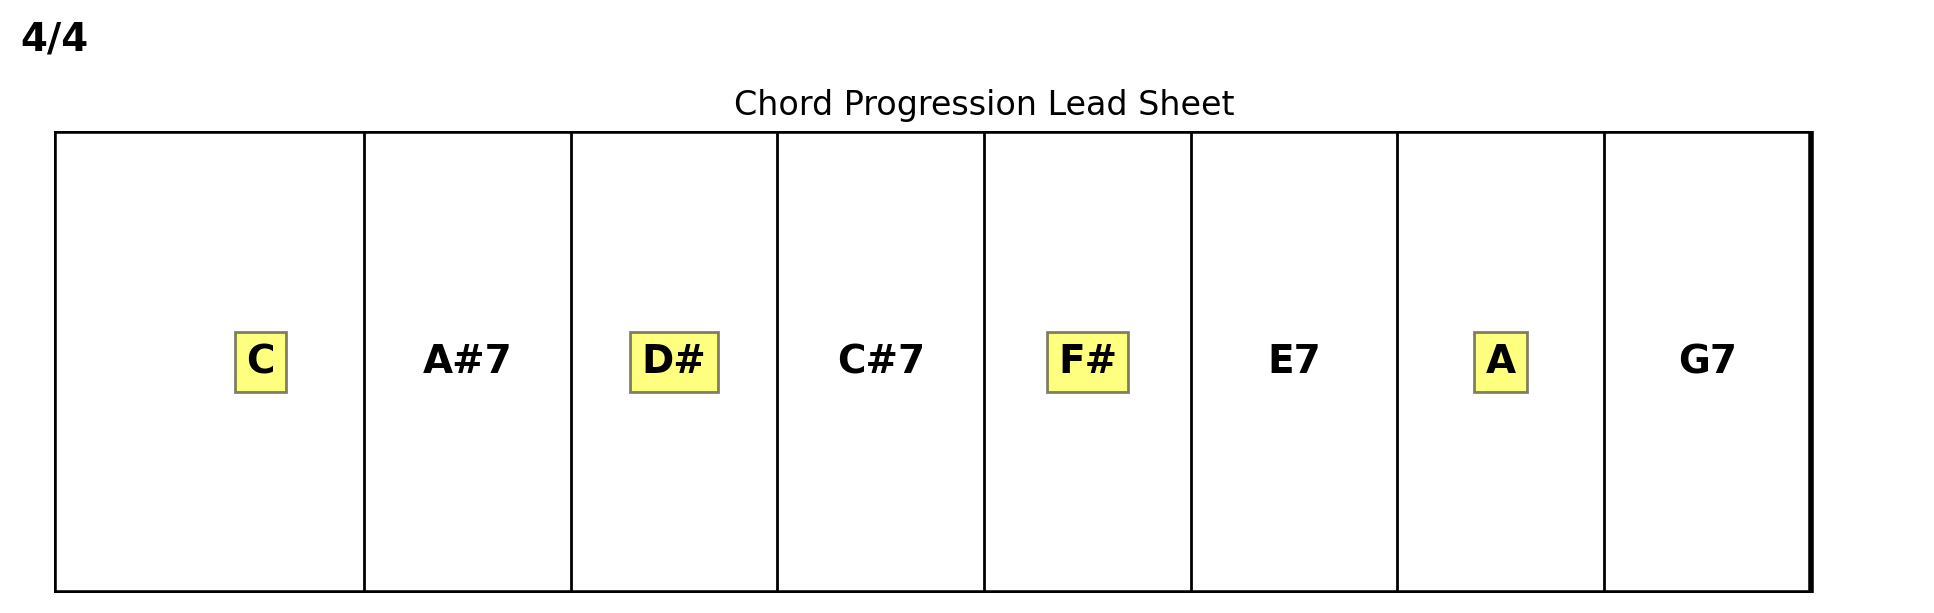

In [9]:
from qiskit import *
from qiskit.circuit.library import QFT
import numpy as np

def generate_similar_progression(key_center, breaking_method, permutation, time_signature):
    # Print the input parameters
    print(f"Original key center: {key_center}")
    print(f"Original breaking method: {breaking_method}")
    print(f"Original permutation: {permutation}")
    print(f"Original time signature: {time_signature}")
    print("\n")  

    
    num_qubits = 4
    qc = QuantumCircuit(num_qubits)
    
    # Initialize the qubits based on the existing progression
    for i in range(num_qubits):
        qc.h(i)
    
    # Apply controlled transformations
    for i in range(num_qubits):
        qc.ry(np.pi/4, i)  
        if i < num_qubits - 1:
            qc.cx(i, i + 1) 

    # Apply QFT
    qc.append(QFT(num_qubits), range(num_qubits))
    qc.measure_all()

    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit).result()
    counts = result.get_counts()

    # Find the most probable state
    most_probable_state = max(counts, key=counts.get)
    new_key_center = note_mapping[most_probable_state]
    
    # Generate a new progression based on the new key center
    if breaking_method == 'minor thirds':
        new_progression = minor_thirds[new_key_center]
    else:
        new_progression = major_thirds[new_key_center]

    
    new_permutation = tuple(new_progression[:len(permutation)])

    new_progression_with_v7 = []
    for i in range(len(new_permutation) - 1):
        new_progression_with_v7.append(new_permutation[i])
        v7_chord = get_v7_chord(new_permutation[i+1])
        if v7_chord:
            new_progression_with_v7.append(v7_chord)
    new_progression_with_v7.append(new_permutation[-1])

    
    v7_of_first_chord = get_v7_chord(new_progression_with_v7[0])
    if v7_of_first_chord:
        new_progression_with_v7.append(v7_of_first_chord)

  
    new_qc_time_sig = QuantumCircuit(2)
    new_qc_time_sig.h(range(2))
    new_qc_time_sig.measure_all()

    new_result_time_sig = simulator.run(transpile(new_qc_time_sig, simulator)).result()
    new_counts_time_sig = new_result_time_sig.get_counts()

    new_most_probable_time_sig = max(new_counts_time_sig, key=new_counts_time_sig.get)
    new_time_signature = time_signatures[new_most_probable_time_sig]

    # Print the new progression details
    print(f"New key center: {new_key_center}")
    print(f"New breaking method: {breaking_method}")
    print(f"New permutation: {new_permutation}")
    print(f"New time signature: {new_time_signature}")

    plot_chord_progression(new_progression_with_v7, new_time_signature)
    play_chord_progression(new_progression_with_v7)

# Example usage of QFT generated progression
generate_similar_progression(key_center, breaking_method, permutation, time_signature)
